<a href="https://colab.research.google.com/github/EiffL/LPTLensingComparison/blob/main/notebooks/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing package
!pip install --quiet git+https://github.com/Eiffl/LPTLensingComparison.git

In [ ]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'

In [ ]:
%pylab inline

import jax
import jax.numpy as jnp
import jax_cosmo as jc

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
# load lsst year 10 settings
from sbi_lens.config import config_lsst_y_10
from sbi_lens.simulator.redshift import subdivide

# Define the cosmology
cosmo = jc.Planck15(Omega_c=0.2664, Omega_b=0.0492, sigma8=0.831, h=0.6727, n_s=0.9645)

# Survey parameters
sigma_e          = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins            = config_lsst_y_10.nbins
a                = config_lsst_y_10.a
b                = config_lsst_y_10.b
z0               = config_lsst_y_10.z0

# Define redshift distribution
nz = jc.redshift.smail_nz(a, b, z0, gals_per_arcmin2=gals_per_arcmin2, zmax=2.6)
nz_shear = subdivide(nz, nbins=nbins, zphot_sigma=0.05)

# Specify the size and resolution of the patch to simulate
field_size = 5.   # transverse size in degrees
field_npix = 60   # number of pixels per side
print("Pixel size in arcmin: ", field_size * 60 / field_npix)

Pixel size in arcmin:  5.0


Text(0.5, 1.0, 'Redshift distribution')

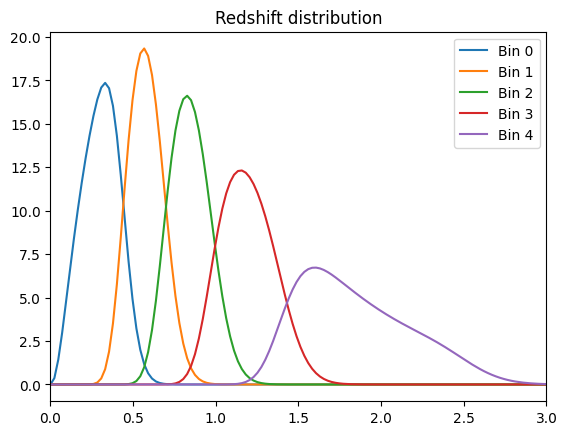

In [ ]:
# Plotting the redshift distribution
z = linspace(0, 3., 128)

for i in range(nbins):
  plot(z, nz_shear[i](z)*nz_shear[i].gals_per_arcmin2, color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,3);
title('Redshift distribution')

In [ ]:
# Now, let's build a full field model
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace, condition, reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

from jax_lensing.model import make_full_field_model

# High resolution settings
# Note: this low resolution on the los impacts a tiny bit the cross-correlation signal,
# but it's probably worth it in terms of speed gains
box_size  = [400., 400., 4000.]     # In Mpc/h
box_shape = [300,  300,  128]       # Number of voxels/particles per side

# Generate the forward model given these survey settings
lensing_model = jax.jit(make_full_field_model( field_size=field_size,
                                            field_npix=field_npix,
                                            box_size=box_size,
                                            box_shape=box_shape))
# Define the probabilistic model
def model():
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling initial conditions
  initial_conditions = numpyro.sample('initial_conditions', dist.Normal(jnp.zeros(box_shape),
                                                                        jnp.ones(box_shape)))

  Omega_c = numpyro.sample("Omega_c", dist.TruncatedNormal(0.2664, 0.2, low=0))
  Omega_b = numpyro.sample("Omega_b", dist.Normal(0.0492, 0.006))
  sigma8 = numpyro.sample("sigma8", dist.Normal(0.831, 0.14))
  h = numpyro.sample("h", dist.Normal(0.6727, 0.063))
  n_s = numpyro.sample("n_s", dist.Normal(0.9645, 0.08))
  w0 = numpyro.sample("w0", dist.TruncatedNormal(-1.0, 0.9, low=-2.0, high=-0.3))

  cosmo = jc.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, sigma8=sigma8,
                       h=h, n_s=n_s, w0=w0, wa=0., Omega_k=0.)

  # Generate random convergence maps
  convergence_maps, _ = lensing_model(cosmo, nz_shear, initial_conditions)

  # Apply noise to the maps (this defines the likelihood)
  observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, sigma_e/jnp.sqrt(nz_shear[i].gals_per_arcmin2*(field_size*60/field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

  return observed_maps

Once the model is defined, it needs to be seeded, and then can be ran and traced if one wants to access all the stochastic variables.

In [ ]:
# condition the model on a given set of parameters
fiducial_model = condition(model, {'Omega_c': cosmo.Omega_c,
                                                    'Omega_b': cosmo.Omega_b,
                                                    'sigma8': cosmo.sigma8,
                                                    'h': cosmo.h,
                                                    'n_s': cosmo.n_s,
                                                    'w0': cosmo.w0})

# sample a mass map and save corresponding true parameters
model_trace = trace(seed(fiducial_model, jax.random.PRNGKey(42))).get_trace()

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


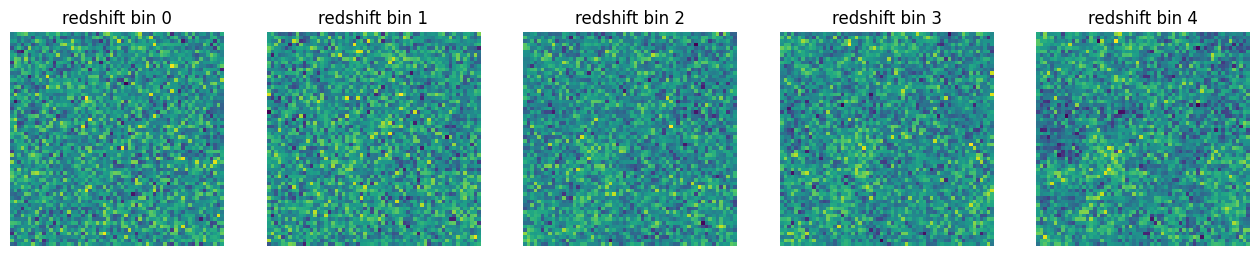

In [ ]:
# plotting the trace
from scipy.ndimage import gaussian_filter

figure(figsize=[16,4])
for i in range(5):
    subplot(1,5,i+1)
    title('redshift bin %d'%i)
    imshow(gaussian_filter(model_trace['kappa_%d'%i]['value'],0.))
    axis('off')

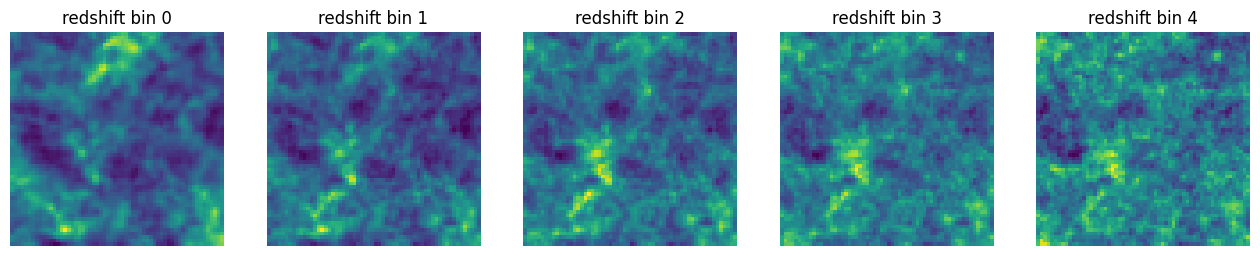

In [ ]:
# plotting the trace
figure(figsize=[16,4])
for i in range(5):
    subplot(1,5,i+1)
    title('redshift bin %d'%i)
    imshow(model_trace['kappa_%d'%i]['fn'].mean)
    axis('off')

## 2pt function inference


In [ ]:
# Let's compute the power spectra from the maps, and condition the prob
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
from functools import partial

l_edges_kmap = np.arange(100.0, 2000.0, 50.0)

ell = ConvergenceMap(model_trace['kappa_0']['value'], angle=field_size * u.deg).cross(
    ConvergenceMap(model_trace['kappa_0']['value'], angle=field_size * u.deg),
    l_edges=l_edges_kmap,
)[0]

ps = []
for i, j in itertools.combinations_with_replacement(range(nbins), 2):
    ps_ij = ConvergenceMap(model_trace['kappa_%i'%i]['value'], angle=field_size * u.deg).cross(
        ConvergenceMap(model_trace['kappa_%i'%j]['value'], angle=field_size * u.deg),
        l_edges=l_edges_kmap,
    )[1]
    ps.append(ps_ij)
ps = np.array(ps)

/usr/local/lib/python3.10/dist-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [ ]:
# Let's build a theory model
from jax_lensing.model import make_2pt_model

# Generate the forward model given these survey settings
theory_model = jax.jit(make_2pt_model(pixel_scale=field_size/field_npix*60,
                                      ell=ell, sigma_e=sigma_e))

cell_theory, cell_noise = theory_model(cosmo, nz_shear)

# Generating the covariance and precision matrix at the fiducial cosmology
tracer = jc.probes.WeakLensing(nz_shear, sigma_e=sigma_e)
C = jc.angular_cl.gaussian_cl_covariance(ell, [tracer], cell_theory,
                                         cell_noise, f_sky = field_size**2/(41_253))
P = jc.sparse.to_dense(jc.sparse.inv(C))
C = jc.sparse.to_dense(C)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [ ]:
# Define the probabilistic model
def theory_prob_model():
  """
  This function defines the top-level forward model for our observations
  """
  Omega_c = numpyro.sample("Omega_c", dist.TruncatedNormal(0.2664, 0.2, low=0))
  Omega_b = numpyro.sample("Omega_b", dist.Normal(0.0492, 0.006))
  sigma8 = numpyro.sample("sigma8", dist.Normal(0.831, 0.14))
  h = numpyro.sample("h", dist.Normal(0.6727, 0.063))
  n_s = numpyro.sample("n_s", dist.Normal(0.9645, 0.08))
  w0 = numpyro.sample("w0", dist.TruncatedNormal(-1.0, 0.9, low=-2.0, high=-0.3))

  cosmo = jc.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, sigma8=sigma8,
                       h=h, n_s=n_s, w0=w0, wa=0., Omega_k=0.)

  # Generate signal
  cell_theory, cell_noise = theory_model(cosmo, nz_shear)

  cl = numpyro.sample(
        "cl",
        dist.MultivariateNormal(cell_theory.flatten() + cell_noise.flatten(), precision_matrix=P, covariance_matrix=C),
    )

  return cl

In [ ]:
# Let's condition the model on observations and sample from it
def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']) and ('cl' not in x['name']) :
        return LocScaleReparam(centered=0)
    else:
        return None

# Let's condition the model on the observed maps
observed_cl_model = condition(theory_prob_model, {'cl': np.stack(ps).flatten()})

# And reparametrize the variables to standardize their scale
observed_cl_model_reparam = reparam(observed_cl_model, config=config)

In [ ]:
# Building the sampling kernel
nuts_kernel = numpyro.infer.NUTS(
    model=observed_cl_model_reparam,
    init_strategy=numpyro.infer.init_to_mean,
    max_tree_depth=3,
    step_size=0.04)

In [ ]:
mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=0,
       num_samples=2000,
       num_chains=16,
       chain_method='vectorized',
      #  thinning=10,
       progress_bar=True
    )

In [ ]:
mcmc.run(jax.random.PRNGKey(0))

sample: 100%|██████████| 2000/2000 [08:12<00:00,  4.06it/s]


In [ ]:
res_ps = mcmc.get_samples()

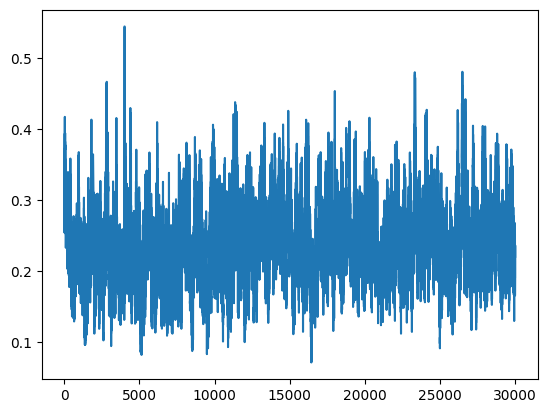

In [ ]:
m = res_ps['Omega_c'] < 0.6
plot(res_ps['Omega_c'][m])

(0.38, 1.25)

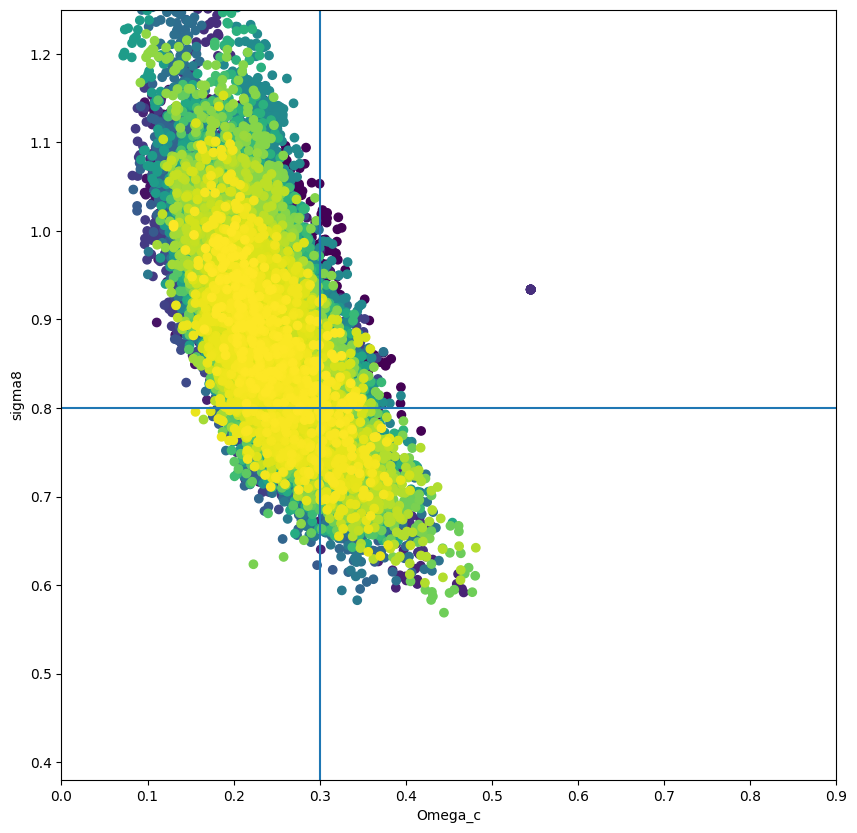

In [ ]:
figure(figsize=[10,10])
scatter(res_ps['Omega_c'][m],
        res_ps['sigma8'][m],
        c=arange(len(res_ps['sigma8'][m])));
axvline(0.3)
axhline(0.8)
xlabel('Omega_c')
ylabel('sigma8')
xlim(0,0.9)
ylim(0.38,1.25)

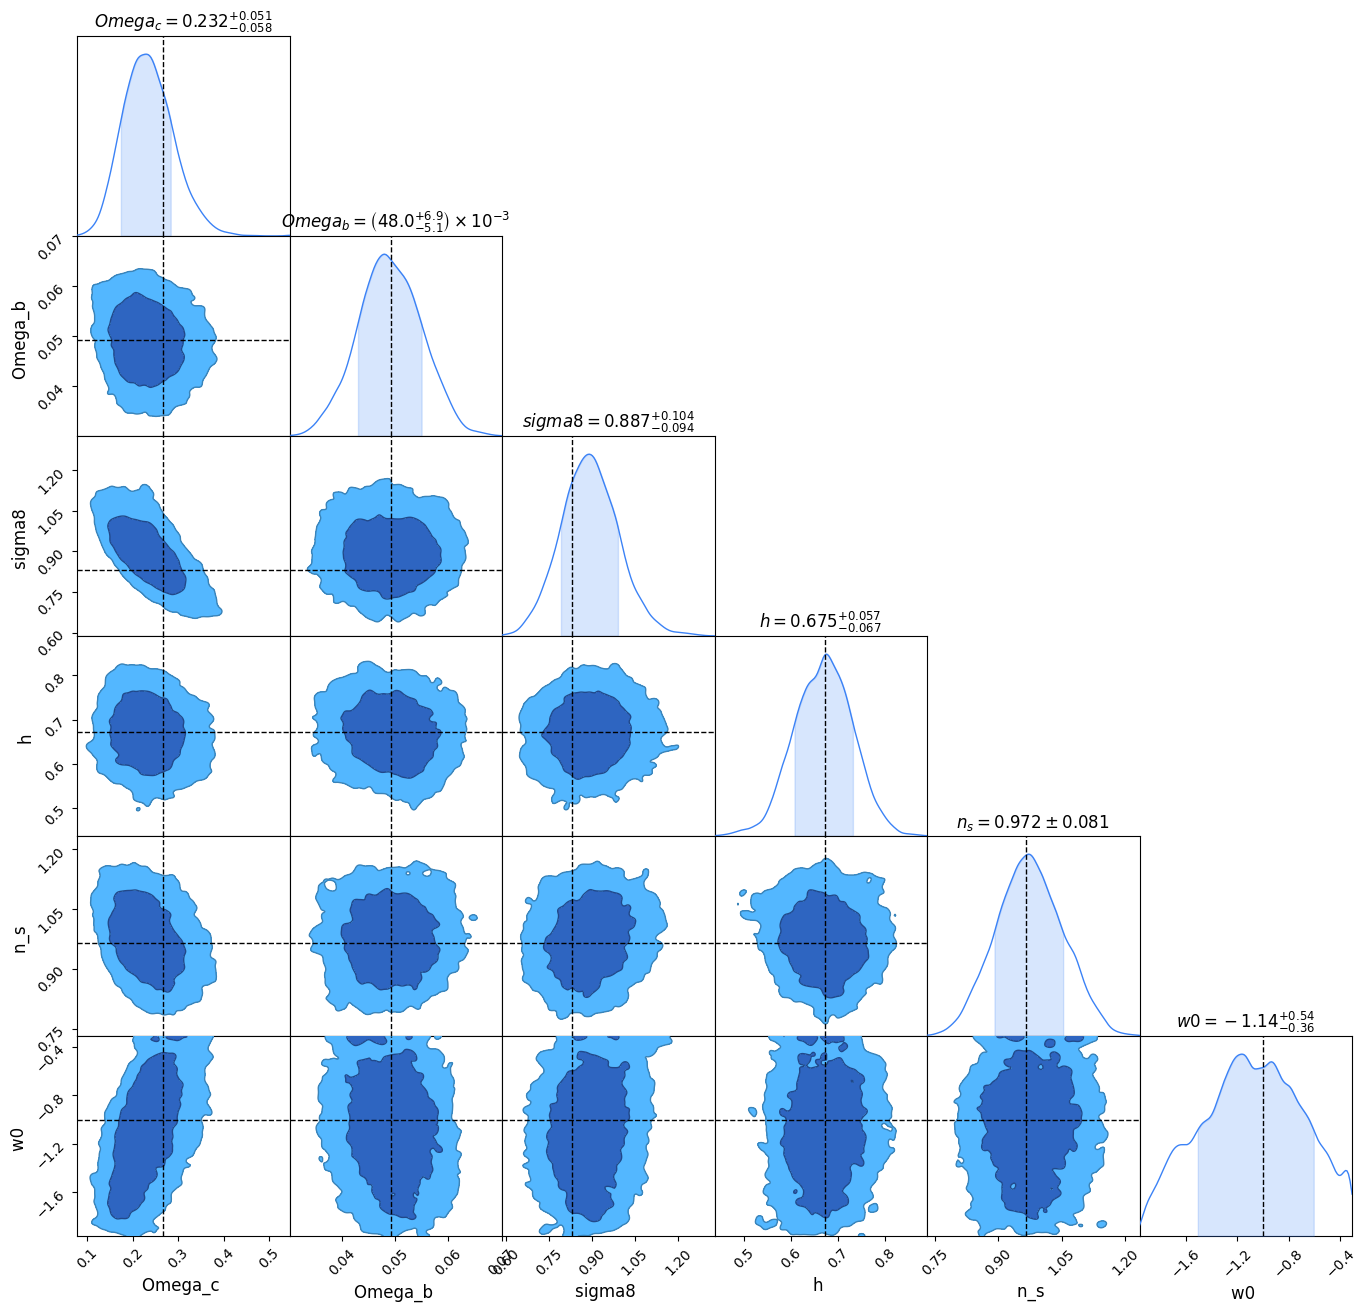

In [ ]:
from chainconsumer import Chain, Truth, PlotConfig, ChainConsumer
import pandas as pd

df = pd.DataFrame({k: np.array(res_ps[k][m]) for k in ['Omega_c', 'Omega_b', 'sigma8', 'h', 'n_s',  'w0']})

c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Posterior'))
c.add_truth(Truth(location={"Omega_c":0.2664, "Omega_b":0.0492, "sigma8":0.831, "h":0.6727, "n_s":0.9645, 'w0':-1.}))
fig = c.plotter.plot(figsize="column")

In [ ]:
# Export the chain
np.savez('ps_chain.npz', res_ps)

## Full Field Inference

Now we do the same thing, but by sampling over the simulator

In [ ]:
def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']) and ('kappa' not in x['name']) and ('initial_conditions' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

# Let's condition the model on the observed maps
observed_model = condition(model, {'kappa_0': model_trace['kappa_0']['value'],
                                  'kappa_1': model_trace['kappa_1']['value'],
                                  'kappa_2': model_trace['kappa_2']['value'],
                                  'kappa_3': model_trace['kappa_3']['value'],
                                  'kappa_4': model_trace['kappa_4']['value'],
                                   })

# And reparametrize the variables to standardize their scale
observed_model_reparam = reparam(observed_model, config=config)

In [ ]:
# Building the sampling kernel
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model_reparam,
    init_strategy=partial(numpyro.infer.init_to_value, values={'omega_c': 0.3,
                                                               'omega_b_decentered': 0.,
                                                               'sigma_8_decentered': 0.,
                                                               'h_0_decentered': 0.,
                                                               'n_s_decentered': 0.,
                                                               'w_0': -1.,
                                                               'initial_conditions': model_trace['initial_conditions']['value']}),
    max_tree_depth=3,
    step_size=0.03)

In [ ]:
mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=0,
       num_samples=200,
      #  num_chains=4,
      #  chain_method='vectorized',
       thinning=10,
       progress_bar=True
    )

In [ ]:
mcmc.run(jax.random.PRNGKey(0))

sample: 100%|██████████| 200/200 [05:22<00:00,  1.61s/it, 7 steps of size 3.00e-02. acc. prob=0.56]


In [ ]:
import pickle

In [ ]:
res = mcmc.get_samples()
# res.pop('initial_conditions')
with open('lensing_fwd_mdl_nbody_0.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Running the next set of samples
for i in range(57, 1000):
    print('round',i,'done')
    mcmc.post_warmup_state = mcmc.last_state
    mcmc.run(mcmc.post_warmup_state.rng_key)
    res = mcmc.get_samples()
    res.pop('initial_conditions')
    with open('lensing_fwd_mdl_nbody_%d.pickle'%(i+1), 'wb') as handle:
        pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

round 57 done


sample: 100%|██████████| 200/200 [04:44<00:00,  1.42s/it, 7 steps of size 3.00e-02. acc. prob=0.57]


round 58 done


sample: 100%|██████████| 200/200 [04:43<00:00,  1.42s/it, 7 steps of size 3.00e-02. acc. prob=0.57]


round 59 done


sample: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it, 7 steps of size 3.00e-02. acc. prob=0.57]


round 60 done


sample: 100%|██████████| 200/200 [04:51<00:00,  1.46s/it, 7 steps of size 3.00e-02. acc. prob=0.57]


round 61 done


sample: 100%|██████████| 200/200 [04:56<00:00,  1.48s/it, 7 steps of size 3.00e-02. acc. prob=0.57]


round 62 done


sample:  32%|███▎      | 65/200 [01:36<03:19,  1.48s/it, 7 steps of size 3.00e-02. acc. prob=0.57]

In [ ]:
from tqdm import tqdm

In [ ]:
# Collating all the results
res = []
for i in tqdm(range(56)):
    with open('lensing_fwd_mdl_nbody_%d.pickle'%i, 'rb') as handle:
        o = pickle.load(handle)
        if 'initial_conditions' in o.keys():
          o.pop('initial_conditions')
        res.append(o)
# Concatenate the chain
res = {k: np.concatenate([r[k] for r in res]) for k in res[0].keys()}

100%|██████████| 56/56 [00:34<00:00,  1.65it/s]


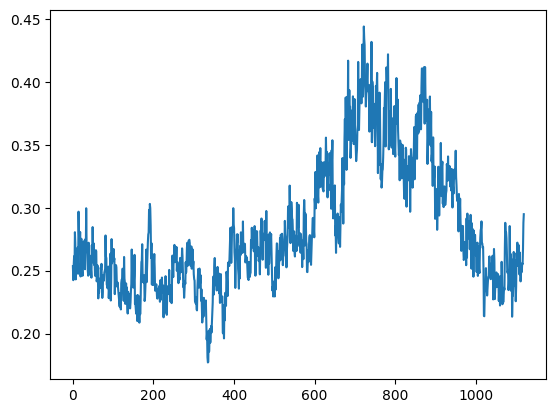

In [ ]:
plot(res['Omega_c'])

(0.38, 1.25)

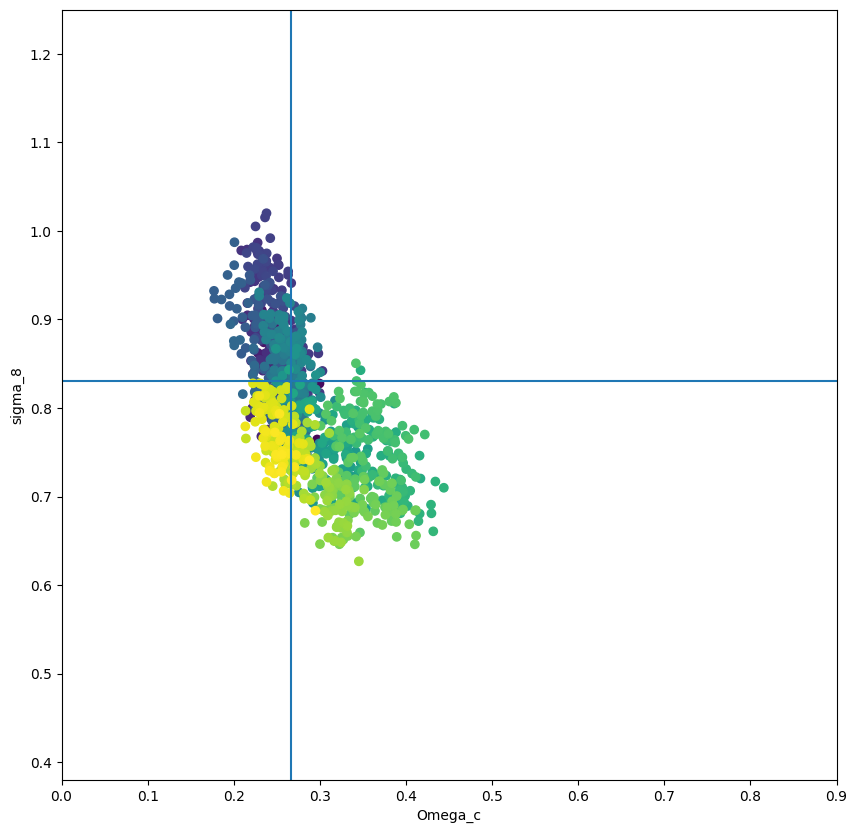

In [ ]:
figure(figsize=[10,10])
scatter(res['Omega_c'],
        res['sigma8'],
        c=arange(len(res['sigma8'])));
axvline(0.2664)
axhline(0.831)
xlabel('Omega_c')
ylabel('sigma_8')
xlim(0,0.9)
ylim(0.38,1.25)

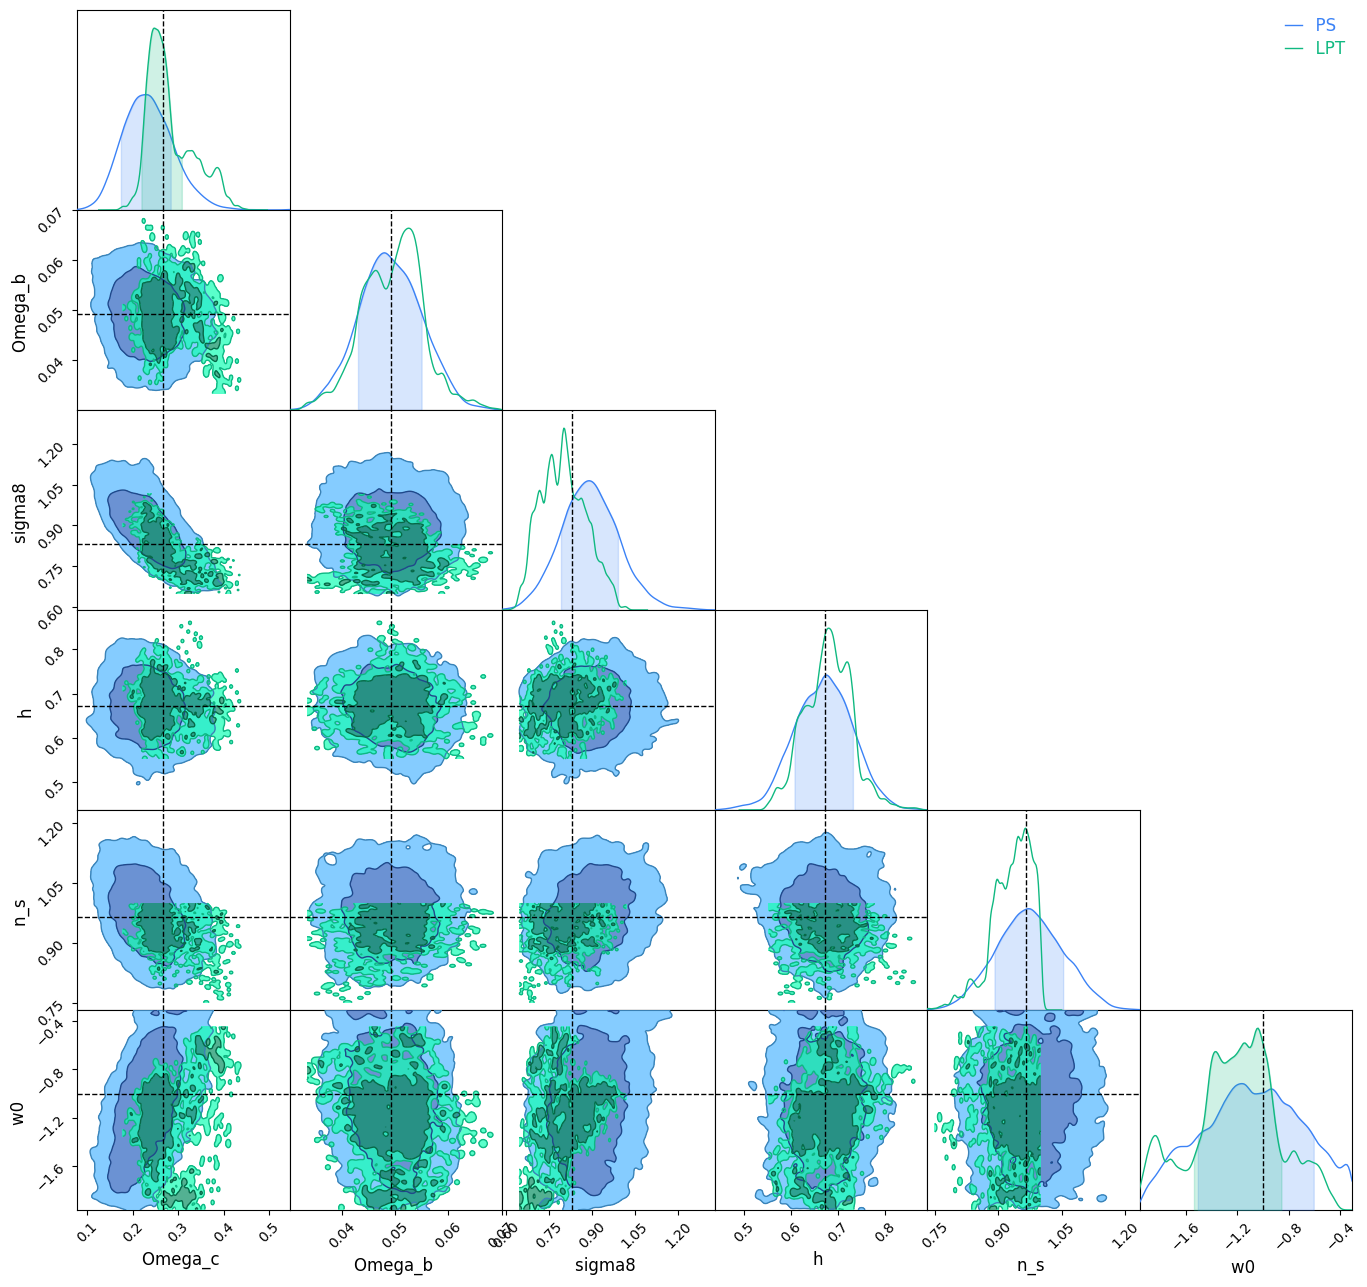

In [ ]:
from chainconsumer import Chain, Truth, PlotConfig, ChainConsumer
import pandas as pd

df = pd.DataFrame({k: np.array(res_ps[k][m]) for k in ['Omega_c', 'Omega_b', 'sigma8', 'h', 'n_s',  'w0']})
df2 = pd.DataFrame({k: np.array(res[k]) for k in ['Omega_c', 'Omega_b', 'sigma8', 'h', 'n_s',  'w0']})

c = ChainConsumer()
c.add_chain(Chain(samples=df, name='PS'))
c.add_chain(Chain(samples=df2, name='LPT'))
c.add_truth(Truth(location={"Omega_c":0.2664, "Omega_b":0.0492, "sigma8":0.831, "h":0.6727, "n_s":0.9645, 'w0':-1.}))
fig = c.plotter.plot(figsize="column")

In [ ]:
# export the chain
np.savez('LSSTY10_LPT_40.npz',
         omega_c=res['Omega_c'],
         omega_b=res['Omega_b'],
         h=res['h'],
         n_s=res['n_s'],
         w0=res['w0'],
         sigma8=res['sigma8'])

In [ ]:
# Making an animation of the lensing field and density field
recs = []
lc = []
for i in range(len(res['Omega_c'])):
    c = jc.Planck15(Omega_c=res['Omega_c'][i], Omega_b=res['Omega_b'][i],
                    h=res['h'][i], n_s=res['n_s'][i], sigma8=res['sigma8'][i], w0=res['w0'][i])
    kappa, lightcone = lensing_model(c, nz_shear, res['initial_conditions'][i])
    yo = lightcone.reshape([300,300, 8, 128//8]).mean(axis=-1)
    recs.append(kappa)
    lc.append(yo.T.reshape(8*300, 300).T)

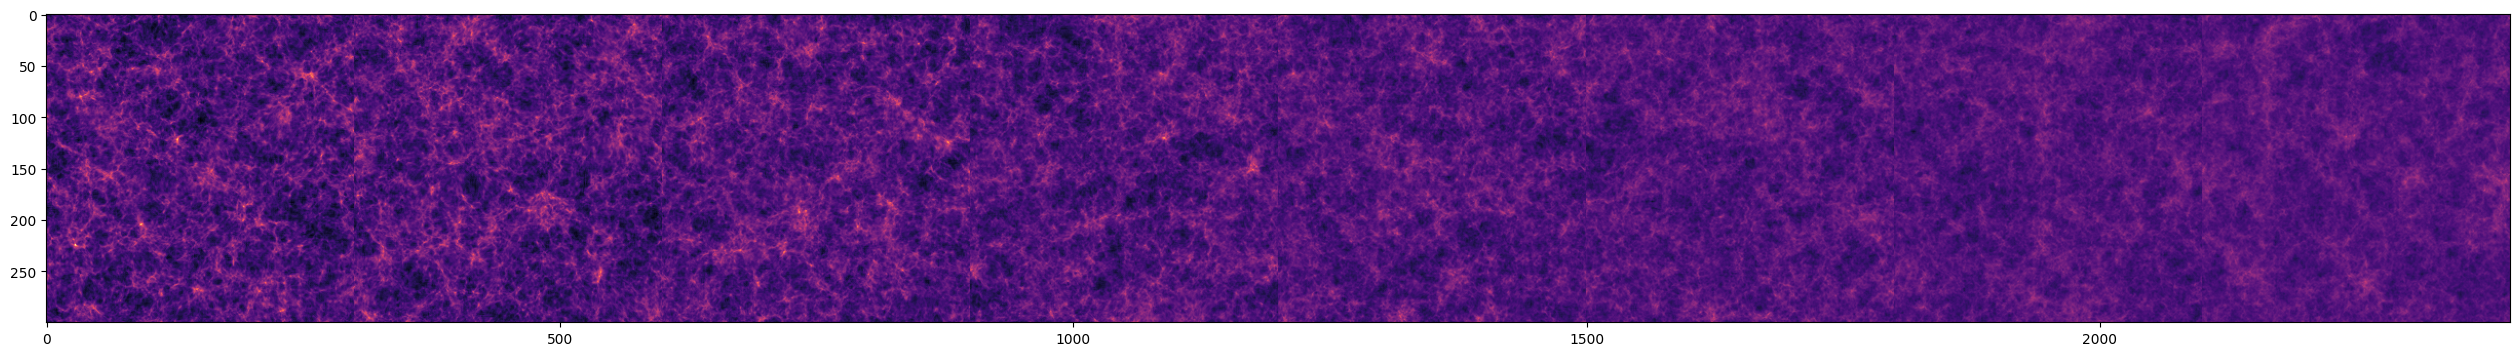

In [ ]:
fig, ax = subplots(figsize=(8*4,4))
imshow(np.stack(lc).mean(axis=0), cmap='magma')

In [ ]:
# The following is borrowed from https://github.com/ericjang/nf-jax/blob/master/nf-tutorial-jax.ipynb
from matplotlib import animation, rc
# from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

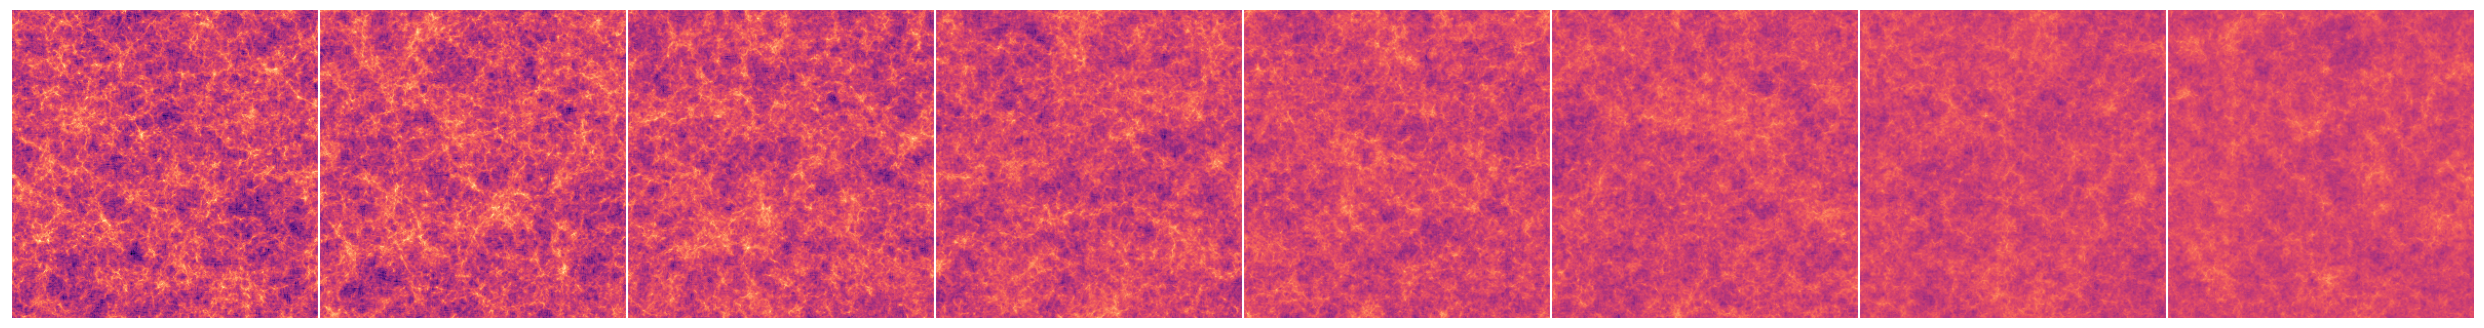

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = subplots(figsize=(8*4,4))

paths = ax.imshow(log10(lc[0]), cmap='magma')
for i in range(8):
    ax.axvline(300*i, color='w')

axis('off');

In [ ]:
def animate(inds):
  paths.set_data(log10(lc[5*inds]))
  return (paths,)

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=20, interval=100, blit=False, )

In [ ]:
anim